## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
import urllib.request
if not os.path.exists('sonnets.txt'):
    url = 'https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/lab02_deep_learning/sonnets.txt'
    filename = 'sonnets.txt'
    urllib.request.urlretrieve(url, filename)

    print("File downloaded successfully.")


File downloaded successfully.


In [3]:

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [5]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

--2024-12-08 13:17:06--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.02s   

2024-12-08 13:17:06 (10.3 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [6]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()

assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [7]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [8]:
# dict <index>:<char>
# Your great code here

# dict <char>:<index>
# Your great code here

token_to_idx = {char: idx for idx, char in enumerate(tokens)}
idx_to_token = {idx: char for idx, char in enumerate(tokens)}

print(f"Number of tokens: {len(tokens)}")

Number of tokens: 83


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [9]:
# Your code here

import numpy as np

def one_hot_encode(index, vocab_size):
    one_hot = np.zeros(vocab_size)
    one_hot[index] = 1.0
    return one_hot

import torch
import torch.nn as nn
import torch.nn.functional as F

class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=1):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

    def initial_state(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [10]:
# Your plot code here

vocab_size = len(tokens)
hidden_size = 128
seq_length = 30
batch_size = 64
epochs = 20
lr = 0.01

model = CharRNN(vocab_size, hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def prepare_batch(text, token_to_idx, seq_length, batch_size):
    input_data, target_data = [], []
    for i in range(0, len(text) - seq_length, seq_length):
        input_seq = text[i:i + seq_length]
        target_seq = text[i + 1:i + seq_length + 1]
        input_data.append([token_to_idx[char] for char in input_seq])
        target_data.append([token_to_idx[char] for char in target_seq])
    return torch.tensor(input_data[:batch_size]), torch.tensor(target_data[:batch_size])

input_data, target_data = prepare_batch(text, token_to_idx, seq_length, batch_size)

import matplotlib.pyplot as plt

loss_history = []

for epoch in range(epochs):
    hidden = model.initial_state(batch_size)
    model.train()
    optimizer.zero_grad()

    output, hidden = model(input_data, hidden)
    loss = criterion(output.view(-1, vocab_size), target_data.view(-1))
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

Epoch 1/20, Loss: 4.4589948654174805
Epoch 2/20, Loss: 3.8029699325561523
Epoch 3/20, Loss: 3.1610982418060303
Epoch 4/20, Loss: 2.939105272293091
Epoch 5/20, Loss: 2.7809770107269287
Epoch 6/20, Loss: 2.686509132385254
Epoch 7/20, Loss: 2.6003024578094482
Epoch 8/20, Loss: 2.51481032371521
Epoch 9/20, Loss: 2.4431517124176025
Epoch 10/20, Loss: 2.3757619857788086
Epoch 11/20, Loss: 2.3163673877716064
Epoch 12/20, Loss: 2.2620019912719727
Epoch 13/20, Loss: 2.2071545124053955
Epoch 14/20, Loss: 2.1528985500335693
Epoch 15/20, Loss: 2.100004196166992
Epoch 16/20, Loss: 2.0470075607299805
Epoch 17/20, Loss: 1.9953621625900269
Epoch 18/20, Loss: 1.9458321332931519
Epoch 19/20, Loss: 1.8963110446929932
Epoch 20/20, Loss: 1.8455322980880737


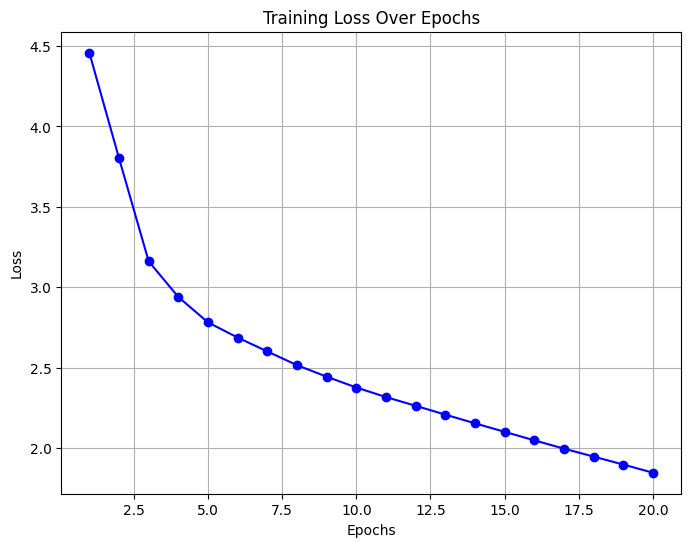

In [11]:
# Plot the loss function
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), loss_history, marker='o', linestyle='-', color='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid()
plt.show()

In [12]:
def generate_text(model, start_str, max_length, temperature):
    model.eval()
    input_seq = torch.tensor([[token_to_idx[char] for char in start_str]])
    hidden = model.initial_state(1)
    output_str = start_str

    for _ in range(max_length - len(start_str)):
        out, hidden = model(input_seq[:, -1:], hidden)
        out = F.softmax(out / temperature, dim=-1).data
        next_char_idx = torch.multinomial(out[0], 1)[0].item()
        next_char = idx_to_token[next_char_idx]
        output_str += next_char
        input_seq = torch.cat((input_seq, torch.tensor([[next_char_idx]])), dim=1)

    return output_str

print(generate_text(model, "shall i", max_length=1000, temperature=1))

shall ieur,
пра.
поз могпи лилять макогих, сас ваваном жин сивгуть,
еспеен,
че дедил мой фрисвсебя:
х9^
пега гевортя же вкогец ново, гри, сченибь мо подостесваз ору-некась воде же вой, онше;многу продо,
для€
седний нетил тнонось иленой, поотрим поден ти вызвор дог,
грилять ластводо;
ла ны,
,
каз
каки кодеть вы
monsieur евый мой,
мзненя нажетя ленего мемудузгатнокон ски ескодриньмузки дегонецумалько такых.
стеныхражежлогихц.
ме ниv



iф

v

востьногдаки зазбылись бажес мноть и lоде
но лим.
ебвалить,
урисудь,
м’abбя мовнемя нутья не;
лранод наку рсегин, вое манемовслевил,
пора, сл недреной узпочех эпична!
неках был;
лей,
сленалью заль и был мой поз.
дать и еведгих
(ся сперонь ивкуост звоеждал
без трить и нестра;
так пр ураан могдиня зоою жевына:
я,
пиолосдет,
мой, ни батв ререднам поге, воредил сногка шутринномузь и орез, мородно,
не дрон мосеньсьбый при негкогней мой,
подой сулять о, праной, яля бле воеммо кокудкугдать дилонегразто инец исенье мой,, саовер евреньмет чегоснасумать и но 

In [13]:
MAX_LENGTH = 100
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function

    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''

    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        print(x_sequence[:, -1].shape, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, i], hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        print(x_sequence.shape, x_sequence, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [14]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

Epoch 1 Loss: 4.41981840133667
Epoch 2 Loss: 4.377956867218018
Epoch 3 Loss: 4.3100266456604
Epoch 4 Loss: 4.139773368835449
Epoch 5 Loss: 3.7292943000793457
Epoch 6 Loss: 3.6116456985473633
Epoch 7 Loss: 3.4702699184417725
Epoch 8 Loss: 3.4216206073760986
Epoch 9 Loss: 3.4190855026245117
Epoch 10 Loss: 3.399625539779663
Epoch 11 Loss: 3.360839366912842
Epoch 12 Loss: 3.3211207389831543
Epoch 13 Loss: 3.2903380393981934
Epoch 14 Loss: 3.2668378353118896
Epoch 15 Loss: 3.24202823638916
Epoch 16 Loss: 3.210866689682007
Epoch 17 Loss: 3.1789512634277344
Epoch 18 Loss: 3.1394174098968506
Epoch 19 Loss: 3.0989081859588623
Epoch 20 Loss: 3.0571229457855225
Epoch 21 Loss: 3.0149741172790527
Epoch 22 Loss: 2.9722673892974854
Epoch 23 Loss: 2.9317314624786377
Epoch 24 Loss: 2.891728401184082
Epoch 25 Loss: 2.855181932449341
Epoch 26 Loss: 2.8174901008605957
Epoch 27 Loss: 2.7833251953125
Epoch 28 Loss: 2.7528836727142334
Epoch 29 Loss: 2.726147413253784
Epoch 30 Loss: 2.7008779048919678
Epoch 3

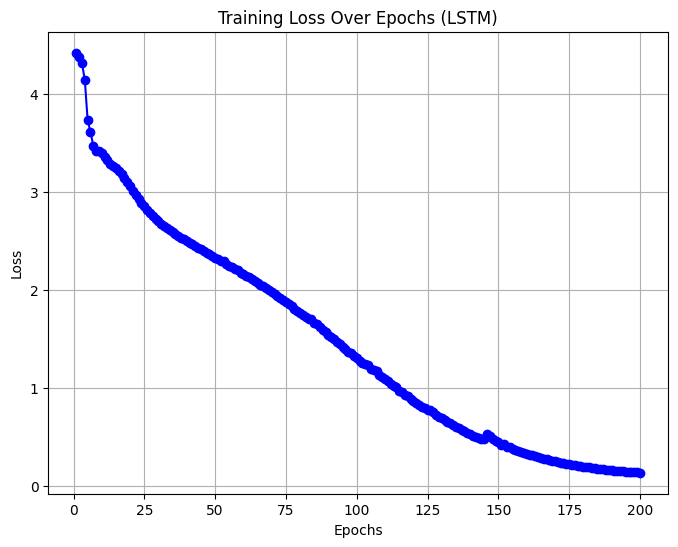

In [15]:
# Your beautiful code here

class CharLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=1):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)

        return out, hidden

    def initial_state(self, batch_size):
        return (torch.zeros(self.n_layers, batch_size, self.hidden_size),
                torch.zeros(self.n_layers, batch_size, self.hidden_size))
    def initialize_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

vocab_size = len(tokens)
hidden_size = 128
seq_length = 30
batch_size = 64
epochs = 200
lr = 0.005

model = CharLSTM(vocab_size, hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

input_data, target_data = prepare_batch(text, token_to_idx, seq_length, batch_size)

model.initialize_weights()

loss_history = []

for epoch in range(epochs):
    hidden = model.initial_state(batch_size)
    model.train()
    optimizer.zero_grad()

    output, hidden = model(input_data, hidden)

    output = output.view(-1, vocab_size)
    target_data = target_data.view(-1)

    loss = criterion(output, target_data)

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)

    optimizer.step()

    loss_history.append(loss.item())
    print(f"Epoch {epoch + 1} Loss: {loss.item()}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), loss_history, marker='o', linestyle='-', color='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs (LSTM)')
plt.grid()
plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [16]:
# Text generation with different temperature values here

def generate_text(model, start_str, max_length, temperature=1.0):
    model.eval()
    input_seq = torch.tensor([[token_to_idx[char] for char in start_str]])
    hidden = model.initial_state(1)
    output_str = start_str

    for _ in range(max_length - len(start_str)):
        out, hidden = model(input_seq[:, -1:], hidden)
        out = F.softmax(out / temperature, dim=-1).data
        next_char_idx = torch.multinomial(out[0], 1)[0].item()
        next_char = idx_to_token[next_char_idx]
        output_str += next_char
        input_seq = torch.cat((input_seq, torch.tensor([[next_char_idx]])), dim=1)

    return output_str

temperature_values = [0.1, 0.2, 0.5, 1.0, 2.0]
for temp in temperature_values:
    generated_text = generate_text(model, "shall i", max_length=100, temperature=temp)
    print(f"Generated Text (Temperature {temp}):\n{generated_text}\n{'='*40}")


Generated Text (Temperature 0.1):
shall ieur l’abbe€, француз убогой,
деласи умали но боля не манил,
чтогу,
не вогка гулял сивеги лост
Generated Text (Temperature 0.2):
shall ieur l’abbe€, француз убогой,
дела мил.
monsieur ее сменил;
рора безным о позаломой,
до, бала 
Generated Text (Temperature 0.5):
shall ieur l’abbe€, француз убогой,
дела севгеро,
слегка,
суждем нила нежной неденной
певгенили в ре
Generated Text (Temperature 1.0):
shall ieur l’abbe€, француи встум долидь знисуть прил намить, не но мо ил,
илчале? н водатку закался
Generated Text (Temperature 2.0):
shall ieuur чf’ятьеннымг
он учей недмны чыдел, труждатьты.
пру-фрак-daasзыл, вожтхоинно писпгегу зся


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [17]:
torch.save(model.state_dict(), 'char_lstm_model.pth')

model = CharLSTM(vocab_size, hidden_size)
model.load_state_dict(torch.load('char_lstm_model.pth'))
model.eval()


generated_text = generate_text(model, "the quick", max_length=100, temperature=1.0)
print(f"Generated Text (Loaded Model):\n{generated_text}")


Generated Text (Loaded Model):
the quickла,
полетви ниденья но важелюде взниси попемужен свебой,
до,
кака беже продя ме,
не кчанил 


<ipython-input-17-c6b379986a04>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('char_lstm_model.pth'))


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)